In [61]:
# code from laptop
from cmath import nan
from traceback import format_exception_only
#from eagerpy import zeros_like
import scipy.io as scio
import numpy as np
import matplotlib.pyplot as plt
import copy
from sklearn.tree import plot_tree
import mtools as mot
from scipy.stats import ranksums
from os.path import exists
from matplotlib.colors import ListedColormap
import seaborn as sns
from matplotlib import gridspec
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib as mpl
import matplotlib.cm as cm
import random
import pickle
import scipy.io as spio
import pandas as pd
import matplotlib.animation as animation
from scipy.signal import find_peaks
import scipy.stats as stats
import configparser
import os

import scipy.signal


## initializtion


In [ ]:
folders = ['481']# choose folder name

place_cells=False# consider only place cells for analysis(list of the cells should be loaded)
cell_types='All'

nrm = np.load('nrm.npy',allow_pickle=True)
clusteringmethod = 'AHC'
Mode = 0 # this belongs to the old code and can be removed
#signal_type = input()
signal_type = 'transients'
#signal_type = 'traces'
fs=20# sampling freq

thr_burts = .5# threshold for burst detection
winlen = 1000*fs# 10 sec cunnks for burst detection

tau=.001# deconv parameter
SpeedLimint=10# is not applied anymore
min_ratio = 1 # threshold to exclude bad templates
#folders = ['478']
# deadtime interval for burst detection
# global Tspare
# Tspare= .5# events window time

speed_thr=5# threshold to remove datapoint with low speed

burst_len='.5s'


trial_thr=2# minimum number of trials requiered for classfication

dataphase='All'#'Arena'# choose one of the followings: ['All', 'Sleep, 'Arena']

config = configparser.ConfigParser()


BASE_DIR = os.getcwd()  # Use current working directory 
# Load config
#config = configparser.ConfigParser()
#config.read('config.ini')

# # Get the data folder path from the config file
# savefolder= config['paths']['savefolder']
# datafolder= config['paths']['datafolder']
# skeletonsfolder= config['paths']['skeletonsfolder']
from pathlib import Path
import configparser
import os  # Import os for cross-platform compatibility

# Detect base directory
try:
    BASE_DIR = Path(__file__).resolve().parent  # For scripts
except NameError:
    BASE_DIR = Path.cwd()  # For Jupyter Notebooks

# Move one level up
BASE_DIR = BASE_DIR.parent

# Load config.ini
config = configparser.ConfigParser()
config.read(os.path.join(os.getcwd(), "config.ini"))

# Construct full paths using pathlib and ensure they end with a separator
skeletonsfolder = str((BASE_DIR / config["paths"]["skeletonsfolder"]).resolve()) + os.sep
savefolder = str((BASE_DIR / config["paths"]["savefolder"]).resolve()) + os.sep
datafolder = str((BASE_DIR / config["paths"]["datafolder"]).resolve()) + os.sep

# Print paths to verify
print("Base Directory:", BASE_DIR)
print("Skeletons Folder:", skeletonsfolder)
print("Save Folder:", savefolder)
print("Data Folder:", datafolder)

sleep__beforelearning = {'478':['session02','session03'],'480':['session02','session03'],'481':['session02','session03'],'483':['session02','session03'],'485':['session02','session03']}# before learning
sleep_leaned_before = {'478':['session02','session03'],'480':[],'481':['session02'],'483':['session02','session03'],'485':['session02']}# learned before task
sleep_leaned_after = {'478':['session05'],'480':[],'481':['session04'],'483':['session05','session06'],'485':['session04']}# learned after task


days= np.arange(0 ,32)# names to load data
daysstr = ["%02d" % (i,) for i in days]
months = np.arange(0,13)
monthsstr = ["%02d" % (i,) for i in months]
year=str(2022)
dates = []
for m in monthsstr:
    for d in daysstr:
        dates.append(year+m+d)


allfolders = ['478','480','481','483','485']

if clusteringmethod =='DB':# clustering algorithgm
    clstr_param={'name':'DB', 'eps':3, 'min_samples': 10}
    cluster_decription = 'Name=' +clstr_param['name']+ ' eps=' +str(clstr_param['eps']) + ' minsample='+ str(clstr_param['min_samples'])+'  SpeedLimint='+ str(SpeedLimint)

elif clusteringmethod =='AHC':
    clstr_param={'name':'AHC', 'fac' : 1,'clnbr':10}
    cluster_decription='Name=' +clstr_param['name']+ ' fac=' +str(clstr_param['fac']) +'  SpeedLimint='+ str(SpeedLimint)



#task = ['task_learning','task_learned','arena']
task = ['arena','task_learning','task_learned','sleep_before','sleep_learned','sleep_learned_after']
print('Taks that are used to compute active cells: ', *task, sep=' and ')




def f(x):
    return int(x)
f2 = np.vectorize(f)




Base Directory: c:\Users\hamed\Desktop\Hamed\Github\TP7
Skeletons Folder: C:\Users\hamed\Desktop\Hamed\Github\TP7\data\GCaMP6f_478-485\skeleton\
Save Folder: C:\Users\hamed\Desktop\Hamed\Github\TP7\results_new\
Data Folder: C:\Users\hamed\Desktop\Hamed\Github\TP7\data\GCaMP6f_478-485\
Taks that are used to compute active cells:  and arena and task_learning and task_learned and sleep_before and sleep_learned and sleep_learned_after


## Get the index of cells that are acitve in all sessions

task_learning
481/20220215_gcamp6f481_task_learning.mat
481/20220216_gcamp6f481_task_learning.mat
481/20220217_gcamp6f481_task_learning.mat
481/20220218_gcamp6f481_task_learning.mat
task_learned
481/20220317_gcamp6f481_task_learned.mat
481/20220318_gcamp6f481_task_learned.mat
481/20220319_gcamp6f481_task_learned.mat
481/20220320_gcamp6f481_task_learned.mat
481/20220327_gcamp6f481_task_learned.mat
Number of active cells during tasks  81


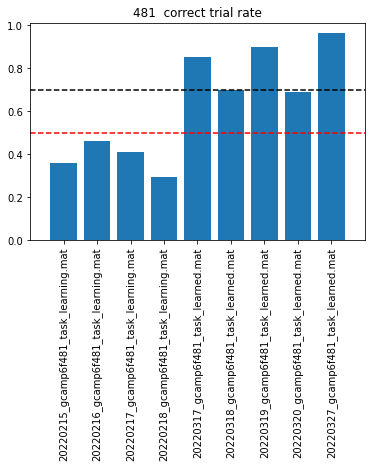

In [63]:
task=['arena']
task = ['task_learning','task_learned']


correctrate=[]
failedrate=[]
true_cell_idx=[]

use_uniqueindex=True

if use_uniqueindex==True:# finding the index of active cells thoughout all sessions
    cmnidx=[]
    cellids=[]# find unique index of all sessions(active cells during all cessions)
    for t in range(len(task)):# task
        print(task[t])
                
        for ii,date in enumerate(dates):# session date
                    
            for i ,fol in enumerate(folders):# animal number
                
                if task[t] == 'sleep_learned_after':
                    filename = date+'_gcamp6f'+fol+'_'+task[t-1]+'.mat'
                else:
                    filename = date+'_gcamp6f'+fol+'_'+task[t]+'.mat'
                            
                if exists(datafolder+fol+'/'+filename):
                    
                    
                    if task[t] == 'sleep_learned_after':
                        filenames = [date+'_gcamp6f'+fol+'_'+task[t]+'.mat'[:-4]+'_'+signal_type]
                    else:
                        filenames = [filename[:-4]+'_'+signal_type]


                    data = mot.loadmat(datafolder+fol+'/'+filename)
                    print(fol+'/'+filename)


                    if (task[t]=='task_learning') | (task[t]=='task_learned'):
                        failedrate.append((filename,len(data['EvtT']['failed_trials'])/(len(data['EvtT']['correct_trials'])+len(data['EvtT']['failed_trials']))))
                        correctrate.append((filename,len(data['EvtT']['correct_trials'])/(len(data['EvtT']['correct_trials'])+len(data['EvtT']['failed_trials']))))


                    true_cell_idx.append(data['metadata']['CellRegCellID'])



name_failedrate=[x[0] for x in correctrate]
value_faliedrate=[x[1] for x in correctrate]


plt.figure()# plot correct trial rate
plt.bar(name_failedrate,value_faliedrate)
plt.xticks(rotation=90)
plt.title(fol+'  correct trial rate')
plt.hlines(.7,-1,len(name_failedrate)+1,'k',linestyles='dashed')
plt.hlines(.5,-1,len(name_failedrate)+1,'r',linestyles='dashed')
plt.xlim([-1,len(name_failedrate)])




#mask_session=[(x,i) for x,i in enumerate(name_failedrate)]
session_mask={}
for i,x in enumerate(name_failedrate): # assign a number to each session for masking sessions
    session_mask[x]=i



newidx=[]
true_cell_idx2=np.array(np.transpose(true_cell_idx))# cell index of all sessions
for x in range(np.shape(true_cell_idx2)[0]):
    if not -1 in (true_cell_idx2[x,:]):
        newidx.append(x)# insex of cells that are active in all sessions

mask_commonids = np.zeros(np.shape(true_cell_idx2)[0],dtype=bool)
mask_commonids[newidx] = True
ncells = len(newidx)# number of active cells in all sessions
failedrate=[]

print('Number of active cells during tasks ', ncells)

# load skleton files and inedex of Place cells

In [ ]:
place_cell_name=''
if dataphase=='Sleep':

    task = ['sleep_before','sleep_learned','sleep_learned_after']
elif dataphase=='Arena':
    task = ['arena']
elif dataphase=='All':

    task=['arena','task_learning' ,'task_learned','sleep_before','sleep_learned','sleep_learned_after']
#skeletonsfolder='C:/Users/hamed/Desktop/Hamed/BCN/sequence/data/GCaMP6f_478-485/skeleton/'
#skeletonsfolder='C:/Users/hamed/Desktop/Hamed/Github/TP7/data/GCaMP6f_478-485/skeleton/'
skel = np.load(skeletonsfolder+fol+'_skeleton.npy',allow_pickle=True) 
skel=skel.item()



# if place_cells:
#     dir_of_run='L'
#     saved_idx=np.load(savefolder+fol+'outward_'+dir_of_run+'_all_correct_all_days_original_bursts_200ms_transients_Allnew2200ms_burst_sig_fraction',allow_pickle=True)
#     sig_pc_L=saved_idx['sig_PC']

#     dir_of_run='R'
#     saved_idx=np.load(savefolder+fol+'outward_'+dir_of_run+'_all_correct_all_days_original_bursts_200ms_transients_Allnew2200ms_burst_sig_fraction',allow_pickle=True)
#     sig_pc_R=saved_idx['sig_PC']




#     significant_pc=sig_pc_L|sig_pc_R

#     #place_cell_name=sigfilename_r[52:60]
#     #cell_types='non_pc'

#     if cell_types=='Non_PC':
#         significant_pc=~significant_pc
# elif place_cells==False:
#         cell_types='All'

## Load data of different sessions and merge them.

In [65]:
# Synthesize trial for sleep to have more samples for fr
def make_trials_for_sleep(x):
        
    # Given period
    # Given period
    start = x[0]
    end = x[1]
    trial_length = 100
    # Generate trials
    trials = []
    current_start = start

    while current_start + trial_length <= end:
        current_end = current_start + trial_length
        trials.append([current_start, current_end])
        current_start = current_end  # Start of next trial is the end of the current one

    trials = np.array(trials)

    return trials

In [ ]:
from helper_functions import separate_in,separate_in_2d_array,linearize_2d_track_single_run
arenasess_nbr=len(session_mask)# arena sessions start from 8 (for masking)
laod_resutls=False
exclude_session=False
if laod_resutls ==False:
    Idtr_f=[0]
    Idtr_c=[0]
    trl_tmps=0
    trl_tmp=[0]
    cnt_trl=0
    tril_idx_msk_all=[0]
    tril_idx_msk=[]
    spks=[]
    data_all_sessions={}
    i0=0
    trcnt=0
    
    for t in range(len(task)):# task
        for ii,date in enumerate(dates):# session date
            # if '20220320'!=date:
            #     continue  
            #print(date)     
            for i ,fol in enumerate(folders):# animal number
                
                if task[t] == 'sleep_learned_after':
                    filename = date+'_gcamp6f'+fol+'_'+task[t-1]+'.mat'
                else:
                    filename = date+'_gcamp6f'+fol+'_'+task[t]+'.mat'
                            
                if exists(datafolder+fol+'/'+filename):
                    
                    
                    if task[t] == 'sleep_learned_after':
                        filenames = [date+'_gcamp6f'+fol+'_'+task[t]+'.mat'[:-4]+'_'+signal_type]
                    else:
                        filenames = [filename[:-4]+'_'+signal_type]

                    descriotor='all_days_original_bursts_neworder'+burst_len
                    
                    
                    print(fol+'/'+filename+task[t])
                    descriotor=descriotor+'_'+signal_type+dataphase
                    data = mot.loadmat(datafolder+fol+'/'+filename)
                    
                    decsig=mot.deconv(data['STMx']['traces'],tau)
                    data['STMx']['deconv']=decsig


                    metadata = (data['metadata'])                   #
                    fs_str = metadata['recordingmethod']['sampling_frequency']
                    fs=float(fs_str[0:2])
                    if fs_str =='kHz':
                        fs *= 1000



                    true_cell_idx3 = np.array(data['metadata']['CellRegCellID'])
                    STMx1 = data['STMx'][signal_type][true_cell_idx3[newidx]]
                    
                    cnt_trl=np.max(tril_idx_msk_all)+1
                    

                    # if place_cells==True:# if you want to analyse only significant pfs

                    #     STMx2=STMx1[significant_pc]
                    #     spks.append(STMx1[significant_pc])
                    #     ncells=len(STMx2)
                        

                    # else:

                    spks.append(STMx1)
                    ncells = len(newidx)
                    STMx2=STMx1
                        #cell_types='all'
                    # compute the population rate of whole session and bursts
                    poprate,id_peaks,bursts,seqs= mot.binned_burst(STMx2,winlen,thr_burts,fs,timewins=[])

                    Spike_times = np.empty(np.shape(STMx2)[0], dtype=float).tolist()# spike time of individual cells for place field analysis



                    for clid in range(np.shape(STMx2)[0]):

                        idpeaks, _ = find_peaks(STMx2[clid,:], height=0,width=1, distance=2)# spike time for each cell

                        #idpeaks, _ = find_peaks(poprate, height=thresh, width=(minwidth,spare*10), distance=spare)


                        Spike_times[clid]=idpeaks

    #SPK=concate_data(spks)
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Concat all data %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

                    
                    if not 'sleep' in task[t]:
                        xloc = np.expand_dims(np.array(data['EvtT']['x']), axis=0)
                        yloc = np.expand_dims(np.array(data['EvtT']['y']), axis=0)                    
                        EvtT = np.concatenate(( xloc,yloc))
                        #poprate_all,id_peaks_all,bursts_all,seqs_all,spike_times_all,rasters_all = mot.binned_burst(STMx2,winlen,thr_burts,fs,)
                        v_all,speed_all,phi_all = mot.velocity(EvtT[0],EvtT[1],fs)
                       




                    if 'sleep' in(task[t]):
                        arenasess_nbr=arenasess_nbr+1
                        session_mask[filename+task[t]]=arenasess_nbr
                        print('sleep is ', filename+task[t])
        




                        if task[t]=='sleep_learned':
                            sessionsname = sleep_leaned_before

                        elif task[t] =='sleep_learned_after':
                            sessionsname = sleep_leaned_after

                        elif task[t] =='sleep_before':
                            sessionsname = sleep__beforelearning
                                
                                

                        ises=0
                        sesslen={}
                        for sesall in data['EvtT']:# save length of each session
                            sesslen[sesall]=(ises,ises+len(data['EvtT'][sesall]['x']))
                            ises=sesslen[sesall][1]+1
                        
                        keys =[task[t]]

                        data_dict_template = {'trial_data':[],'pop_rate':[],'xloc':[],'yloc':[],'fr':[],'seq_mask':[],
                                    'id_peaks':[],'bursts':[],'speed':[],'passid':[],'lin_pos':[],'loc':data['EvtT'],'corr':data['EvtT'],
                                    'Spike_times_cells':[],'t':[],'extract':[],'seqs':[],'odd_even_mask_seqs':[],'fr_cell':[],'correct_trial_idx_mask':[],'failed_trial_idx_mask':[],
                                    'correct_trial_idx_mask_fr':[],'correct_trial_idx_mask_burst':[],'failed_trial_idx_mask_fr':[],'failed_trial_idx_mask_burst':[],'trial_idx_mask':[],
                                    'trial_idx_mask2':[],'trial_numbers':[],'binary_spike':[],'binary_spike_cells':[],'correct_failed_mask':[],'correct_failed_bursts_mask':[],'correct_failed_fr_mask':[]}
                        # Creating the main dictionary
                        #main_dict = {key: dict(data_dict_template) for key in keys}

                        #main_dict = {key: copy.deepcopy(data_dict_template) for key in keys}
                        main_dict={}
                        main_dict[task[t]]=data_dict_template

                        speeds=np.zeros_like(poprate)
                        t_stamps=np.arange(STMx2.shape[1])

                        cond_key=task[t]
                        sleep_transients=np.empty((len(STMx2), 0))
                        for ises, sesname in enumerate(sessionsname[fol]):
                            #if sesname =='session02' or sesname =='session03':# at these sessions animal is sleeping
                            #filenames.append(filenames[0]+'_'+sesname)# devide data into different sleep sessions
                            print(sesname)
                            
                            Xloc=np.expand_dims(data['EvtT'][sesname]['x'], axis=0)
                            Yloc=np.expand_dims(data['EvtT'][sesname]['y'], axis=0)

                            #xloc.extend(data['EvtT'][sesname]['x'])
                           # yloc.extend(data['EvtT'][sesname]['y'])
                            STMx1 = data['STMx'][signal_type][true_cell_idx3[newidx]]
                            
                            new_array=(np.squeeze(STMx2)[:,sesslen[sesname][0]:sesslen[sesname][1]])# Data of sleep
                            sleep_transients = np.concatenate((sleep_transients, new_array), axis=1)# Data of sleep all sessions

                            x=np.asarray(sesslen[sesname])

                            trials_synth=make_trials_for_sleep(x)
                            mask = (id_peaks >= x[0]) & (id_peaks < x[1])

                            binaryspike=np.zeros(len(poprate[sesslen[sesname][0]:sesslen[sesname][1]]))
                            binaryspike[np.asarray(id_peaks)[mask] - x[0]]=1
                            main_dict[cond_key]['binary_spike'].extend(binaryspike)

                            main_dict[cond_key]['trial_data'].append(np.array(STMx2[:, x[0]:x[1]]))
                            #main_dict[leannkeys]['trial_data'].append(x)
                            
                            main_dict[cond_key]['pop_rate'].extend(poprate[x[0]:x[1]])
                            main_dict[cond_key]['xloc'].extend(0*np.ones(len(poprate[x[0]:x[1]])) )
                            main_dict[cond_key]['yloc'].extend(0*np.ones(len(poprate[x[0]:x[1]])) )





                            #main_dict[cond_key]['fr'].append(sum(mask) / (x[1] - x[0]))


                            for trl_slp in trials_synth:
                                mask_trl=(id_peaks >=trl_slp[0]) & (id_peaks < trl_slp[1])
                                main_dict[cond_key]['fr'].append(sum(mask_trl) / (trl_slp[1] - trl_slp[0]))



                            main_dict[cond_key]['seq_mask'].extend(arenasess_nbr * np.ones(len(np.asarray(seqs)[mask])))
                            main_dict[cond_key]['id_peaks'].extend( np.asarray(id_peaks)[mask] - x[0] + i0)
                            main_dict[cond_key]['bursts'].extend(np.asarray(bursts)[mask])
                            main_dict[cond_key]['speed'].extend(speeds[x[0]:x[1]])
                            main_dict[cond_key]['passid'].append([x[0],x[1]])
                            main_dict[cond_key]['t'].extend(t_stamps[x[0]:x[1]] - x[0] )
                            main_dict[cond_key]['extract'].extend(np.transpose(np.array(STMx2[:, x[0]:x[1]])))
                            main_dict[cond_key]['seqs'].extend(np.asarray(seqs)[mask])
                            #main_dict[cond_key]['trial_numbers'].extend(trls*np.ones(len(poprate[x[0]:x[1]]))+trcnt )

                            # since sleep data dont have correct or failed trials i set it -2
                            main_dict[cond_key]["correct_failed_bursts_mask"].extend(-2*np.ones(len(np.asarray(seqs)[mask])).astype(int))
                            main_dict[cond_key]["correct_failed_mask"].extend(-2*np.ones(len(poprate[x[0]:x[1]])))
                            main_dict[cond_key]["correct_failed_fr_mask"].extend(-2*np.ones(1).astype(int))




                            cell_spike_binary=np.zeros((len(Spike_times),len(poprate[x[0]:x[1]])))
                            for ineron in range(len(Spike_times)):
                                mask_n=(np.asarray(Spike_times[ineron])>= x[0]) & (np.asarray(Spike_times[ineron])< x[1])
                                cell_spike_binary[ineron,np.asarray(Spike_times[ineron])[mask_n] - x[0]]=1# binary vectro representing the time of each event for individual cells


                            main_dict[cond_key]['binary_spike_cells'].extend(np.transpose(cell_spike_binary))

                            # in spleep i put zero for all animal positions
                            main_dict[cond_key]['lin_pos'].extend(0*np.ones(len(poprate[x[0]:x[1]])) )

                            i0= len(poprate[x[0]:x[1]])+i0
                                
                        
                        
                            trcnt=trcnt+ises

                        #sess_data,tril_idx_msk_all=get_seq(Alltr,trl_idx,poprate,id_peaks,bursts,Spike_times,ncells,seqs,STMx2,data,speeds,session_mask,filename,tracks,ind1,ind2,skel,)
                        data_all_sessions[filename+cond_key]=main_dict
                        data_all_sessions[filename+cond_key].update({'correct_trials': data['EvtT']})
                        #loc=data['EvtT']['x'],data['EvtT']['y']
                        loc=np.zeros_like(t_stamps),np.zeros_like(t_stamps)# zero for sleep position
                        data_all_sessions[filename+cond_key].update({'loc':loc})
                                                
                                            



















                    if 'arena' in(task[t]):
                        print('arena is ', filename+task[t])
                        arenasess_nbr=arenasess_nbr+1
                        session_mask[filename]=arenasess_nbr
                        xloc = np.expand_dims(np.array(data['EvtT']['x']), axis=0)
                        yloc = np.expand_dims(np.array(data['EvtT']['y']), axis=0)                    
                        EvtT = np.concatenate(( xloc,yloc))
                        v_all,speeds,phi_all = mot.velocity(EvtT[0],EvtT[1],fs)    
                        t_stamps=np.arange(STMx2.shape[1])    
                        for arenakeys in (data['EvtT']):                            
                           

                            if ('inward'in arenakeys) | ('outward' in arenakeys):# to ignore x and y
                                cond_name = 'arena_'+arenakeys+date

                                
                                selected_trials = np.array(data['EvtT'][arenakeys])      
                                cond_trials = np.array(selected_trials.reshape(int(len(selected_trials)/2), 2))# trials of one condition

                                tracks=data['EvtT']['x'] ,data['EvtT']['y']
                                sess_data={}

                                trl_tmps=trl_tmps+trl_tmp[-1]
                                Left_trial_number=int(len(data['EvtT']['outward_L_side'])/2)
                                Right_trial_number=int(len(data['EvtT']['outward_R_side'])/2)

                                L_R={'L':Left_trial_number,'R':Right_trial_number}

                                keys = [
                                    'arena_outward_L',  
                                    'arena_outward_R', 
                                    'arena_inward_L' , 'arena_inward_R', 
                                    'correct_trials', 'loc'
                                ]

                                data_dict_template = {'trial_data':[],'pop_rate':[],'xloc':[],'yloc':[],'fr':[],'seq_mask':[],
                                            'id_peaks':[],'bursts':[],'speed':[],'passid':[],'lin_pos':[],'loc':data['EvtT'],'corr':data['EvtT'],
                                            'Spike_times_cells':[],'t':[],'extract':[],'seqs':[],'odd_even_mask_seqs':[],'fr_cell':[],'correct_trial_idx_mask':[],'failed_trial_idx_mask':[],
                                            'correct_trial_idx_mask_fr':[],'correct_trial_idx_mask_burst':[],'failed_trial_idx_mask_fr':[],'failed_trial_idx_mask_burst':[],'trial_idx_mask':[],
                                            'trial_idx_mask2':[],'trial_numbers':[],'binary_spike':[],'binary_spike_cells':[],'correct_failed_mask':[],'correct_failed_bursts_mask':[],'correct_failed_fr_mask':[]}
                                # Creating the main dictionary
                                #main_dict = {key: dict(data_dict_template) for key in keys}

                                main_dict = {key: copy.deepcopy(data_dict_template) for key in keys}



                                for l_r in L_R.keys():# itterate first left and then right trials
                                    
                                    for trls in range(L_R[l_r]):
                                    

                                        for leannkeys in (data['EvtT']):      # within condtions                     
                                            

                                            if   (l_r in leannkeys) & ((not('x'in leannkeys)) & (not('y'in leannkeys))& (not('correct_trials'in leannkeys))& (not('failed_trials'in leannkeys))& (not('trial_list'in leannkeys))&(not('sampling'in leannkeys))|('sampling_L'in leannkeys)|('sampling_R'in leannkeys)):
                                                #print(leannkeys)

                                                sess_data[leannkeys]={'trial_data':[],'pop_rate':[],'xloc':[],'yloc':[],'fr':[],'seq_mask':[],
                                                'id_peaks':[],'bursts':[],'speed':[],'passid':[],'lin_pos':[],'loc':data['EvtT'],'corr':data['EvtT'],
                                                'Spike_times_cells':[],'t':[],'extract':[],'seqs':[],'odd_even_mask_seqs':[],'fr_cell':[],'correct_trial_idx_mask':[],'failed_trial_idx_mask':[],
                                                'correct_trial_idx_mask_fr':[],'correct_trial_idx_mask_burst':[],'failed_trial_idx_mask_fr':[],'failed_trial_idx_mask_burst':[],'trial_idx_mask':[],
                                                'trial_idx_mask2':[],'trial_numbers':[]}


                                                cond_name = task[t]+'_'+leannkeys+'_'+date

                                                selected_trials = np.array(data['EvtT'][leannkeys])      
                                                cond_trials = np.array(selected_trials.reshape(int(len(selected_trials)/2), 2))# trials of one condition

                                                Alltr=cond_trials

                                                x = Alltr[trls]
                                                if x[1] > x[0]:
                                                    
                                                
                                                       

                                                    mask = (id_peaks >= x[0]) & (id_peaks < x[1])
                                                    cond_key=leannkeys
                                                    if 'outward' in leannkeys:
                                                        cond_key='arena_outward_'+l_r# merge side and center

                                                    if 'inward' in leannkeys:
                                                        cond_key='arena_inward_'+l_r


                                                    binaryspike=np.zeros(len(poprate[x[0]:x[1]]))
                                                    binaryspike[np.asarray(id_peaks)[mask] - x[0]]=1
                                                    main_dict[cond_key]['binary_spike'].extend(binaryspike)

                                                    main_dict[cond_key]['trial_data'].append(np.array(STMx2[:, x[0]:x[1]]))
                                                    #main_dict[leannkeys]['trial_data'].append(x)
                                                    
                                                    main_dict[cond_key]['pop_rate'].extend(poprate[x[0]:x[1]])
                                                    main_dict[cond_key]['xloc'].extend(data['EvtT']['x'][x[0]:x[1]])
                                                    main_dict[cond_key]['yloc'].extend(data['EvtT']['y'][x[0]:x[1]])
                                                    main_dict[cond_key]['fr'].append(sum(mask) / (x[1] - x[0]))
                                                    main_dict[cond_key]['seq_mask'].extend(arenasess_nbr * np.ones(len(np.asarray(seqs)[mask])))
                                                    main_dict[cond_key]['id_peaks'].extend( np.asarray(id_peaks)[mask] - x[0] + i0)
                                                    main_dict[cond_key]['bursts'].extend(np.asarray(bursts)[mask])
                                                    main_dict[cond_key]['speed'].extend(speeds[x[0]:x[1]])
                                                    main_dict[cond_key]['passid'].append([x[0],x[1]])
                                                    main_dict[cond_key]['t'].extend(t_stamps[x[0]:x[1]] - x[0] )
                                                    main_dict[cond_key]['extract'].extend(np.transpose(np.array(STMx2[:, x[0]:x[1]])))
                                                    main_dict[cond_key]['seqs'].extend(np.asarray(seqs)[mask])
                                                    main_dict[cond_key]['trial_numbers'].extend(trls*np.ones(len(poprate[x[0]:x[1]]))+trcnt )

                                                    # since arena data dont have correct or failed trials i set it -1
                                                    main_dict[cond_key]["correct_failed_bursts_mask"].extend(-1*np.ones(len(np.asarray(seqs)[mask])).astype(int))
                                                    main_dict[cond_key]["correct_failed_mask"].extend(-1*np.ones(len(poprate[x[0]:x[1]])))
                                                    main_dict[cond_key]["correct_failed_fr_mask"].extend(-1*np.ones(1).astype(int))

                                                    cell_spike_binary=np.zeros((len(Spike_times),len(poprate[x[0]:x[1]])))
                                                    for ineron in range(len(Spike_times)):
                                                        mask_n=(np.asarray(Spike_times[ineron])>= x[0]) & (np.asarray(Spike_times[ineron])< x[1])
                                                        cell_spike_binary[ineron,np.asarray(Spike_times[ineron])[mask_n] - x[0]]=1# binary vectro representing the time of each event for individual cells
                                                    main_dict[cond_key]['binary_spike_cells'].extend(np.transpose(cell_spike_binary))

                                                    



                                                    trial_spikes_allcells = [np.asarray(xx)[(xx >= x[0]) & (xx < x[1])] for xx in np.asarray(Spike_times)]
                                                    trial_spikes_allcells = [arr - x[0] + i0 if arr.size > 0 else arr for arr in trial_spikes_allcells]
                                                    main_dict[cond_key]['Spike_times_cells'].append(trial_spikes_allcells)

                                                    #mot.merge_spike_times(data_dict["Spike_times_mask_all_cells"], ncells)

                                                    ind1=x[0]
                                                    ind2=x[1]    
                                                    if leannkeys.split('_')[1] == 'L':
                                                        main_dict[cond_key]['lin_pos'].extend(linearize_2d_track_single_run(tracks, ind1, ind2, skel, is_left=True))
                                                    elif leannkeys.split('_')[1] == 'R':
                                                        main_dict[cond_key]['lin_pos'].extend(linearize_2d_track_single_run(tracks, ind1, ind2, skel, is_left=False))



                                                    #i0 = x[1] - x[0] + i0
                                                    i0= len(poprate[x[0]:x[1]])+i0
                                    trcnt=trcnt+trls

                                #sess_data,tril_idx_msk_all=get_seq(Alltr,trl_idx,poprate,id_peaks,bursts,Spike_times,ncells,seqs,STMx2,data,speeds,session_mask,filename,tracks,ind1,ind2,skel,)
                                data_all_sessions[filename]=main_dict
                                data_all_sessions[filename].update({'correct_trials': data['EvtT']})
                                loc=data['EvtT']['x'],data['EvtT']['y']
                                data_all_sessions[filename].update({'loc':loc})
                        
                        

                    if   (task[t]=='task_learned')|(task[t]=='task_learning'):
                        #print(filename+' failed=',len(data['EvtT']['failed_trials'])/(len(data['EvtT']['correct_trials'])+len(data['EvtT']['failed_trials'])))
                        #failedrate.append((filename,len(data['EvtT']['failed_trials'])/(len(data['EvtT']['correct_trials'])+len(data['EvtT']['failed_trials']))))
                        print('task is ', filename+task[t])
                        t_stamps=np.arange(STMx2.shape[1])
                        xloc = np.expand_dims(np.array(data['EvtT']['x']), axis=0)
                        yloc = np.expand_dims(np.array(data['EvtT']['y']), axis=0)                    
                        EvtT = np.concatenate(( xloc,yloc))
                        #poprate_all,id_peaks_all,bursts_all,seqs_all,spike_times_all,rasters_all = mot.binned_burst(STMx2,winlen,thr_burts,fs,)
                        v_all,speeds,phi_all = mot.velocity(EvtT[0],EvtT[1],fs)
                        


                        selected_corrects = np.array(data['EvtT']['correct_trials']) # correct trials of entire session
                        correct_trials = np.array(selected_corrects.reshape(int(len(selected_corrects)/2), 2))

                        selected_false = np.array(data['EvtT']['failed_trials'])  # failed trials of entire session
                        false_trials = np.array(selected_false.reshape(int(len(selected_false)/2), 2))


                        trl_idx = np.vstack((correct_trials,false_trials))
                        
                        for itlid,tlid in enumerate(trl_idx):
                            tril_idx_msk.extend(itlid*np.ones(int(tlid[1]-tlid[0])))




                        tracks=data['EvtT']['x'] ,data['EvtT']['y']
                        sess_data={}

                        trl_tmps=trl_tmps+trl_tmp[-1]
                        Left_trial_number=int(len(data['EvtT']['sampling_L'])/2)
                        Right_trial_number=int(len(data['EvtT']['sampling_R'])/2)

                        L_R={'L':Left_trial_number,'R':Right_trial_number}
                        # keys = [
                        #     'sampling_L', 'sampling_R', 'outward_L_center', 'outward_L_side', 
                        #     'outward_R_center', 'outward_R_side', 'reward_L', 'reward_R', 
                        #     'inward_L_side', 'inward_L_center', 'inward_R_side', 'inward_R_center', 
                        #     'correct_trials', 'loc'
                        # ]

                        keys = [
                            'sampling_L', 'sampling_R', 'outward_L',  
                            'outward_R', 'reward_L', 'reward_R', 
                            'inward_L' , 'inward_R', 
                            'correct_trials', 'loc'
                        ]

                        data_dict_template = {'trial_data':[],'pop_rate':[],'xloc':[],'yloc':[],'fr':[],'seq_mask':[],
                                    'id_peaks':[],'bursts':[],'speed':[],'passid':[],'lin_pos':[],'loc':data['EvtT'],'corr':data['EvtT']['correct_trials'],
                                    'Spike_times_cells':[],'t':[],'extract':[],'seqs':[],'odd_even_mask_seqs':[],'fr_cell':[],'correct_trial_idx_mask':[],'failed_trial_idx_mask':[],
                                    'correct_trial_idx_mask_fr':[],'correct_trial_idx_mask_burst':[],'failed_trial_idx_mask_fr':[],'failed_trial_idx_mask_burst':[],'trial_idx_mask':[],
                                    'trial_idx_mask2':[],'trial_numbers':[],'binary_spike':[],'binary_spike_cells':[],'correct_failed_mask':[],'correct_failed_bursts_mask':[],'correct_failed_fr_mask':[]}
                        # Creating the main dictionary
                        #main_dict = {key: dict(data_dict_template) for key in keys}

                        main_dict = {key: copy.deepcopy(data_dict_template) for key in keys}


                        for l_r in L_R.keys():# itterate first left and then right trials
                            
                            for trls in range(L_R[l_r]):
                            

                                for leannkeys in (data['EvtT']):      # within condtions                     
                                    

                                    if   (l_r in leannkeys) & ((not('x'in leannkeys)) & (not('y'in leannkeys))& (not('correct_trials'in leannkeys))& (not('failed_trials'in leannkeys))& (not('trial_list'in leannkeys))&(not('sampling'in leannkeys))|('sampling_L'in leannkeys)|('sampling_R'in leannkeys)):
                                        #print(leannkeys)

                                        sess_data[leannkeys]={'trial_data':[],'pop_rate':[],'xloc':[],'yloc':[],'fr':[],'seq_mask':[],
                                        'id_peaks':[],'bursts':[],'speed':[],'passid':[],'lin_pos':[],'loc':data['EvtT'],'corr':data['EvtT']['correct_trials'],
                                        'Spike_times_cells':[],'t':[],'extract':[],'seqs':[],'odd_even_mask_seqs':[],'fr_cell':[],'correct_trial_idx_mask':[],'failed_trial_idx_mask':[],
                                        'correct_trial_idx_mask_fr':[],'correct_trial_idx_mask_burst':[],'failed_trial_idx_mask_fr':[],'failed_trial_idx_mask_burst':[],'trial_idx_mask':[],
                                        'trial_idx_mask2':[],'trial_numbers':[]}


                                        cond_name = task[t]+'_'+leannkeys+'_'+date

                                        selected_trials = np.array(data['EvtT'][leannkeys])      
                                        cond_trials = np.array(selected_trials.reshape(int(len(selected_trials)/2), 2))# trials of one condition



                                        correxindex,idtr_c= mot.find_correct_index(cond_trials,correct_trials)# find correct trials of one condition
                                        fasleindex,idtr_f= mot.find_correct_index(cond_trials,false_trials)# find failed trials of one condition



                                        
                                        Cortr=[(x ,'correct') for i, x in enumerate(cond_trials[correxindex])]
                                        Failtr=[(x ,'failed') for i, x in enumerate(cond_trials[fasleindex])]
                                        Alltr=[]
                                        if (len(Failtr)>0) &   (len(Cortr)>0):
                                            Alltr=np.vstack((Cortr,Failtr))# mix of correct and failed trial indices
                                        elif  (len(Failtr)==0) &   (len(Cortr)>0):
                                            Alltr=Cortr#  correct trial indices
                                        elif  (len(Cortr)==0) &   (len(Failtr)>0):
                                            Alltr=Failtr#  failed trial indices




                                        # Rest of your code
                                        #trl_nbr=0
                                    #for itr, X in enumerate(Alltr):# trials within a condtion
                                        x = Alltr[trls][0]
                                        trltyp = Alltr[trls][1]
                                        if x[1] > x[0]:
                                            
                                        

                                            matching_index = None
                                            for idtrl, trial in enumerate(trl_idx):
                                                if ((x[0] >= trial[0] and x[1] <= trial[1])):
                                                    matching_index = idtrl+1
                                                    #print(matching_index)
                                                    break
                                            
                                                
                                            #trl_nbr=trl_nbr+1

                                            mask = (id_peaks >= x[0]) & (id_peaks < x[1])
                                            cond_key=leannkeys
                                            if 'outward' in leannkeys:
                                                cond_key='outward_'+l_r# merge side and center

                                            if 'inward' in leannkeys:
                                                cond_key='inward_'+l_r


                                            binaryspike=np.zeros(len(poprate[x[0]:x[1]]))
                                            binaryspike[np.asarray(id_peaks)[mask] - x[0]]=1
                                            main_dict[cond_key]['binary_spike'].extend(binaryspike)

                                            main_dict[cond_key]['trial_data'].append(np.array(STMx2[:, x[0]:x[1]]))
                                            #main_dict[leannkeys]['trial_data'].append(x)
                                            
                                            main_dict[cond_key]['pop_rate'].extend(poprate[x[0]:x[1]])
                                            main_dict[cond_key]['xloc'].extend(data['EvtT']['x'][x[0]:x[1]])
                                            main_dict[cond_key]['yloc'].extend(data['EvtT']['y'][x[0]:x[1]])
                                            main_dict[cond_key]['fr'].append(sum(mask) / (x[1] - x[0]))
                                            main_dict[cond_key]['seq_mask'].extend(session_mask[filename] * np.ones(len(np.asarray(seqs)[mask])))
                                            main_dict[cond_key]['id_peaks'].extend( np.asarray(id_peaks)[mask] - x[0] + i0)
                                            main_dict[cond_key]['bursts'].extend(np.asarray(bursts)[mask])
                                            main_dict[cond_key]['speed'].extend(speeds[x[0]:x[1]])
                                            main_dict[cond_key]['passid'].append([x[0],x[1]])
                                            main_dict[cond_key]['t'].extend(t_stamps[x[0]:x[1]] - x[0] )
                                            main_dict[cond_key]['extract'].extend(np.transpose(np.array(STMx2[:, x[0]:x[1]])))
                                            main_dict[cond_key]['seqs'].extend(np.asarray(seqs)[mask])
                                            main_dict[cond_key]['trial_numbers'].extend(trls*np.ones(len(poprate[x[0]:x[1]]))+trcnt )


                                            cell_spike_binary=np.zeros((len(Spike_times),len(poprate[x[0]:x[1]])))
                                            for ineron in range(len(Spike_times)):
                                                mask_n=(np.asarray(Spike_times[ineron])>= x[0]) & (np.asarray(Spike_times[ineron])< x[1])
                                                cell_spike_binary[ineron,np.asarray(Spike_times[ineron])[mask_n] - x[0]]=1# binary vectro representing the time of each event for individual cells
                                            main_dict[cond_key]['binary_spike_cells'].extend(np.transpose(cell_spike_binary))

                                            

                                            if trltyp == 'correct':

                                                main_dict[cond_key]["correct_failed_mask"].extend(np.ones(len(poprate[x[0]:x[1]])))
                                                main_dict[cond_key]["correct_failed_bursts_mask"].extend(np.ones(len(np.asarray(seqs)[mask])).astype(int))
                                                main_dict[cond_key]["correct_failed_fr_mask"].extend(np.ones(1).astype(int))

                                                main_dict[cond_key]['correct_trial_idx_mask'].extend(1 * np.ones(len(poprate[x[0]:x[1]])))
                                                main_dict[cond_key]['correct_trial_idx_mask_fr'].extend(1* np.ones(len(poprate[x[0]:x[1]])))
                                                main_dict[cond_key]['correct_trial_idx_mask_burst'].extend(1 * np.ones(len(poprate[x[0]:x[1]])))

                                            if trltyp == 'failed':


                                                main_dict[cond_key]["correct_failed_mask"].extend(np.zeros(len(poprate[x[0]:x[1]])))
                                                main_dict[cond_key]["correct_failed_bursts_mask"].extend(np.zeros(len(np.asarray(seqs)[mask])).astype(int))
                                                main_dict[cond_key]["correct_failed_fr_mask"].extend(np.zeros(1).astype(int))

                                                main_dict[cond_key]['failed_trial_idx_mask'].extend(0 * np.ones(len(poprate[x[0]:x[1]])))
                                                main_dict[cond_key]['failed_trial_idx_mask_fr'].extend(0* np.ones(len(poprate[x[0]:x[1]])))
                                                main_dict[cond_key]['failed_trial_idx_mask_burst'].extend(0 * np.ones(len(poprate[x[0]:x[1]])))



                                            trial_spikes_allcells = [np.asarray(xx)[(xx >= x[0]) & (xx < x[1])] for xx in np.asarray(Spike_times)]
                                            trial_spikes_allcells = [arr - x[0] + i0 if arr.size > 0 else arr for arr in trial_spikes_allcells]
                                            main_dict[cond_key]['Spike_times_cells'].append(trial_spikes_allcells)

                                            #mot.merge_spike_times(data_dict["Spike_times_mask_all_cells"], ncells)

                                            ind1=x[0]
                                            ind2=x[1]    
                                            if leannkeys.split('_')[1] == 'L':
                                                main_dict[cond_key]['lin_pos'].extend(linearize_2d_track_single_run(tracks, ind1, ind2, skel, is_left=True))
                                            elif leannkeys.split('_')[1] == 'R':
                                                main_dict[cond_key]['lin_pos'].extend(linearize_2d_track_single_run(tracks, ind1, ind2, skel, is_left=False))



                                            #i0 = x[1] - x[0] + i0
                                            i0= len(poprate[x[0]:x[1]])+i0
                            trcnt=trcnt+trls

                        #sess_data,tril_idx_msk_all=get_seq(Alltr,trl_idx,poprate,id_peaks,bursts,Spike_times,ncells,seqs,STMx2,data,speeds,session_mask,filename,tracks,ind1,ind2,skel,)
                        data_all_sessions[filename]=main_dict
                        data_all_sessions[filename].update({'correct_trials': data['EvtT']['correct_trials']})
                        loc=data['EvtT']['x'],data['EvtT']['y']
                        data_all_sessions[filename].update({'loc':loc})

481/20220201_gcamp6f481_arena.matarena
Burst length is  0.5
arena is  20220201_gcamp6f481_arena.matarena


C:\Users\hamed\AppData\Local\Temp\ipykernel_1896\1306389620.py:356: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  main_dict[cond_key]['seq_mask'].extend(arenasess_nbr * np.ones(len(np.asarray(seqs)[mask])))
C:\Users\hamed\AppData\Local\Temp\ipykernel_1896\1306389620.py:363: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  main_dict[cond_key]['seqs'].extend(np.asarray(seqs)[mask])
C:\Users\hamed\AppData\Local\Temp\ipykernel_1896\1306389620.py:367: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lis

481/20220202_gcamp6f481_arena.matarena
Burst length is  0.5
arena is  20220202_gcamp6f481_arena.matarena
481/20220203_gcamp6f481_arena.matarena
Burst length is  0.5
arena is  20220203_gcamp6f481_arena.matarena
481/20220215_gcamp6f481_task_learning.mattask_learning
Burst length is  0.5
task is  20220215_gcamp6f481_task_learning.mattask_learning


C:\Users\hamed\AppData\Local\Temp\ipykernel_1896\1306389620.py:552: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  main_dict[cond_key]['seq_mask'].extend(session_mask[filename] * np.ones(len(np.asarray(seqs)[mask])))
C:\Users\hamed\AppData\Local\Temp\ipykernel_1896\1306389620.py:559: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  main_dict[cond_key]['seqs'].extend(np.asarray(seqs)[mask])
C:\Users\hamed\AppData\Local\Temp\ipykernel_1896\1306389620.py:574: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tup

481/20220216_gcamp6f481_task_learning.mattask_learning
Burst length is  0.5
task is  20220216_gcamp6f481_task_learning.mattask_learning
481/20220217_gcamp6f481_task_learning.mattask_learning
Burst length is  0.5
task is  20220217_gcamp6f481_task_learning.mattask_learning
481/20220218_gcamp6f481_task_learning.mattask_learning
Burst length is  0.5
task is  20220218_gcamp6f481_task_learning.mattask_learning
481/20220317_gcamp6f481_task_learned.mattask_learned
Burst length is  0.5
task is  20220317_gcamp6f481_task_learned.mattask_learned
481/20220318_gcamp6f481_task_learned.mattask_learned
Burst length is  0.5
task is  20220318_gcamp6f481_task_learned.mattask_learned
481/20220319_gcamp6f481_task_learned.mattask_learned
Burst length is  0.5
task is  20220319_gcamp6f481_task_learned.mattask_learned
481/20220320_gcamp6f481_task_learned.mattask_learned
Burst length is  0.5
task is  20220320_gcamp6f481_task_learned.mattask_learned
481/20220327_gcamp6f481_task_learned.mattask_learned
Burst lengt

C:\Users\hamed\AppData\Local\Temp\ipykernel_1896\1306389620.py:196: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  main_dict[cond_key]['seq_mask'].extend(arenasess_nbr * np.ones(len(np.asarray(seqs)[mask])))
C:\Users\hamed\AppData\Local\Temp\ipykernel_1896\1306389620.py:203: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  main_dict[cond_key]['seqs'].extend(np.asarray(seqs)[mask])
C:\Users\hamed\AppData\Local\Temp\ipykernel_1896\1306389620.py:207: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lis

Burst length is  0.5
Burst length is  0.5
sleep is  20220326_gcamp6f481_sleep_learned.matsleep_learned
session02
481/20220326_gcamp6f481_sleep_learned.matsleep_learned_after
Burst length is  0.5
Burst length is  0.5
sleep is  20220326_gcamp6f481_sleep_learned.matsleep_learned_after
session04


In [67]:
# combined_dicts = [data_all_sessions, session_mask ,data]
# with open(savefolder+fol+task[0],'wb') as f:
#     pickle.dump(combined_dicts, f)       


In [68]:
all_data={'trial_data':[],'pop_rate':[],'xloc':[],'yloc':[],'fr':[],'seq_mask':[],
'id_peaks':[],'bursts':[],'speed':[],'passid':[],'lin_pos':[],'loc':data['EvtT'],'corr':data['EvtT'],
'Spike_times_cells':[],'t':[],'extract':[],'seqs':[]}

#conds=['sampling_L', 'sampling_R', 'outward_L_center', 'outward_L_side', 'outward_R_center', 'outward_R_side', 'reward_L', 'reward_R', 'inward_L_side', 'inward_L_center', 'inward_R_side', 'inward_R_center']

conds=['sampling_L',
 'sampling_R',
 'outward_L',
 'outward_R',
 'reward_L',
 'reward_R',
 'inward_L',
 'inward_R']


cond_number = dict(zip(conds, np.arange(len(conds))))# make mask values for each task
cond_names=cond_number

sess_info={'trial_data':[],'pop_rate':[],'xloc':[],'yloc':[],'fr':[],'seq_mask':[],
'id_peaks':[],'bursts':[],'speed':[],'passid':[],'lin_pos':[],'loc':data['EvtT'],'corr':data['EvtT'],
'Spike_times_cells':[[] for _ in range(ncells)],'t':[],'extract':[],'seqs':[],'ids_clust':[]}

## Generate masks for differenct behaviral epochs

In [69]:

cond_info={}
phase_idx=[]
#conds=['sampling_L', 'sampling_R', 'outward_L_center', 'outward_L_side', 'outward_R_center', 'outward_R_side', 'reward_L', 'reward_R', 'inward_L_side', 'inward_L_center', 'inward_R_side', 'inward_R_center']
sess_idx=[]
cond_idx=[]
burst_idx_cond=[]
burst_idx_phase=[]
burst_idx_sess=[]
i0=0

features=['pop_rate', 'xloc', 'yloc', 'fr', 'seq_mask', 'speed',  'lin_pos','bursts','seqs']
features_t=['t', 'id_peaks']

sess_info={'trial_data':[],'pop_rate':[],'xloc':[],'yloc':[],'fr':[],'seq_mask':[],
'id_peaks':[],'bursts':[],'speed':[],'passid':[],'lin_pos':[],'loc':data['EvtT'],'corr':data['EvtT'],
'Spike_times_cells':[[] for _ in range(ncells)],'t':[],'extract':[],'seqs':[],'trial_idx_mask':[]}

cell_mask_cond = [[] for _ in range(ncells)]
cell_mask_sess = [[] for _ in range(ncells)]
cell_mask_phase = [[] for _ in range(ncells)]


Masks={'conditions':[],'sessions':[],'phases':[],'bursts_cond':[],'bursts_sess':[],'bursts_phase':[],
'odd_even':[],'odd_even_seqs':[],'cell_cond':  cell_mask_cond,'cell_sess':  cell_mask_sess,'cell_phase': cell_mask_phase,
'correct_failed':[],'correct_failed_seqs':[],'correct_failed_fr':[],'fr_phase':[],'fr_cond':[],'fr_sess':[],'odd_even_fr':[],
'correct_trial_idx_mask':[0],'failed_trial_idx_mask':[0],'trial_idx_mask':[],'correct_trial_idx_mask_fr':[],'correct_trial_idx_mask_burst':[],
'failed_trial_idx_mask_fr':[],'failed_trial_idx_mask_burst':[],'trial_number':[],'Spike_binary_cells':[],'Spike_binary':[]}


binray_spike_all=[]
binray_spike_all_cells=[]
a=[[] for _ in range(ncells)]
for sess_name in data_all_sessions.keys():

    odd_even_mask_sess=[]
    sess_trace=[]

    #for trl in np.unique(data_all_sessions[sess_name]['sampling_L ']['trial_numbers']):
    if 'arena' in sess_name:


        conds=['arena_outward_L','arena_outward_R', 
              'arena_inward_L' , 'arena_inward_R' ]
        cond_number = dict(zip(conds, 8+np.arange(len(conds))))# make mask values for each task
        cond_number_arena=cond_number
        

In [70]:
cond_number_arena

{'arena_outward_L': 8,
 'arena_outward_R': 9,
 'arena_inward_L': 10,
 'arena_inward_R': 11}

In [71]:
#conds=['sampling_L', 'sampling_R', 'outward_L_center', 'outward_L_side', 'outward_R_center', 'outward_R_side', 'reward_L', 'reward_R', 'inward_L_side', 'inward_L_center', 'inward_R_side', 'inward_R_center']
#cond_number = dict(zip(conds, np.arange(len(conds))))# make mask values for each task


cond_info={}
phase_idx=[]
#conds=['sampling_L', 'sampling_R', 'outward_L_center', 'outward_L_side', 'outward_R_center', 'outward_R_side', 'reward_L', 'reward_R', 'inward_L_side', 'inward_L_center', 'inward_R_side', 'inward_R_center']
sess_idx=[]
cond_idx=[]
burst_idx_cond=[]
burst_idx_phase=[]
burst_idx_sess=[]
i0=0

features=['pop_rate', 'xloc', 'yloc', 'fr', 'seq_mask', 'speed',  'lin_pos','bursts','seqs']
features_t=['t', 'id_peaks']

sess_info={'trial_data':[],'pop_rate':[],'xloc':[],'yloc':[],'fr':[],'seq_mask':[],
'id_peaks':[],'bursts':[],'speed':[],'passid':[],'lin_pos':[],'loc':data['EvtT'],'corr':data['EvtT'],
'Spike_times_cells':[[] for _ in range(ncells)],'t':[],'extract':[],'seqs':[],'trial_idx_mask':[]}

cell_mask_cond = [[] for _ in range(ncells)]
cell_mask_sess = [[] for _ in range(ncells)]
cell_mask_phase = [[] for _ in range(ncells)]


Masks={'conditions':[],'sessions':[],'phases':[],'bursts_cond':[],'bursts_sess':[],'bursts_phase':[],
'odd_even':[],'odd_even_seqs':[],'cell_cond':  cell_mask_cond,'cell_sess':  cell_mask_sess,'cell_phase': cell_mask_phase,
'correct_failed':[],'correct_failed_seqs':[],'correct_failed_fr':[],'fr_phase':[],'fr_cond':[],'fr_sess':[],'odd_even_fr':[],
'correct_trial_idx_mask':[0],'failed_trial_idx_mask':[0],'trial_idx_mask':[],'correct_trial_idx_mask_fr':[],'correct_trial_idx_mask_burst':[],
'failed_trial_idx_mask_fr':[],'failed_trial_idx_mask_burst':[],'trial_number':[],'Spike_binary_cells':[],'Spike_binary':[]}


binray_spike_all=[]
binray_spike_all_cells=[]
a=[[] for _ in range(ncells)]
for sess_name in data_all_sessions.keys():

    odd_even_mask_sess=[]
    sess_trace=[]

    #for trl in np.unique(data_all_sessions[sess_name]['sampling_L ']['trial_numbers']):
    if 'arena' in sess_name:
        conds=['arena_outward_L','arena_outward_R', 
              'arena_inward_L' , 'arena_inward_R' ]
        cond_number = dict(zip(conds, 8+np.arange(len(conds))))# make mask values for each task
        cond_number_arena=cond_number
        
    elif 'sleep' in sess_name:
        conds= [key for key in data_all_sessions[sess_name].keys() if 'sleep' in key]

        # ['sleep_before', 'sleep_learned_after',
        #       ]
        cond_number = dict(zip(conds, 12+np.arange(len(conds))))# make mask values for each task
        cond_number_sleep=cond_number

    else:
        conds=['sampling_L',
                'sampling_R',
                'outward_L',
                'outward_R',
                'reward_L',
                'reward_R',
                'inward_L',
                'inward_R']
        cond_number = dict(zip(conds, np.arange(len(conds))))# make mask values for each task



    for condname in conds:

        cond_info[condname]={'trial_data':[],'pop_rate':[],'xloc':[],'yloc':[],'fr':[],'seq_mask':[],
        'id_peaks':[],'bursts':[],'speed':[],'passid':[],'lin_pos':[],'loc':data['EvtT'],'corr':data['EvtT'],
        'Spike_times_cells':[],'t':[],'extract':[],'trial_number':[]}
        #trl_mask=np.asarray(data_all_sessions[sess_name][condname]['trial_numbers'])==trl
        if ('correct_trials' not in condname) | ( 'loc'  not in condname):




            
            if len(data_all_sessions[sess_name][condname]['t'])>0:
                t0=data_all_sessions[sess_name][condname]['t'][0]# first time of  each chunk

                cond_info[condname]['id_peaks'].extend(data_all_sessions[sess_name][condname]['id_peaks'])
                cond_info[condname]['pop_rate'].extend(np.asarray(data_all_sessions[sess_name][condname]['pop_rate']))


                for fname in features:
                    sess_info[fname].extend(data_all_sessions[sess_name][condname][fname])# pooled data of all conds of alls sess

                # for fname in features_t:
                #     temp_data=np.asarray(data_all_sessions[sess_name][condname][fname])
                #     if len(temp_data)>0:
                #         temp_data=temp_data+i0-t0
                #         sess_info[fname].extend(temp_data)

                binray_spike_all.extend(data_all_sessions[sess_name][condname]['binary_spike'])

                binray_spike_all_cells.extend(data_all_sessions[sess_name][condname]['binary_spike_cells'])


                if  len(sess_info['extract']) == 0:  # If the list is empty
                    sess_info['extract']= np.array(np.transpose(data_all_sessions[sess_name][condname]['extract']))
                    #print("The list is empty")
                else:
                    sess_info['extract'] = np.hstack((sess_info['extract'], np.array(np.transpose(data_all_sessions[sess_name][condname]['extract']))))


                if 'learning' in sess_name:
                    phi=0
                elif 'learned' in sess_name and not 'sleep' in sess_name:
                    phi=1
                elif 'arena' in sess_name:
                    phi=2

                elif 'sleep' in sess_name:
                    phi=3
                for i, subsublist in enumerate(np.transpose(data_all_sessions[sess_name][condname]['binary_spike_cells'])):
                    #sess_info['Spike_times_cells'][i].extend(subsublist-t0+i0)# add spike time of each cell from another session/contition
                    # indicates to what condition and waht session this burst belong
                    
                    
                    # Masks['cell_cond'][i].extend(cond_number[condname]*np.ones(len(data_all_sessions[sess_name][condname]['Spike_times_cells'][i])))
                    # Masks['cell_sess'][i].extend(session_mask[sess_name]*np.ones(len(data_all_sessions[sess_name][condname]['Spike_times_cells'][i])))
                    # Masks['cell_phase'][i].extend(phi*np.ones(len(data_all_sessions[sess_name][condname]['Spike_times_cells'][i])))

                    Masks['cell_cond'][i].extend(cond_number[condname]*np.ones(np.sum(subsublist==1)))
                    Masks['cell_sess'][i].extend(session_mask[sess_name]*np.ones(np.sum(subsublist==1)))
                    Masks['cell_phase'][i].extend(phi*np.ones(np.sum(subsublist==1)))
                    #a[i].append(np.sum(data_all_sessions[sess_name][condname]['binary_spike_cells'][i]==1))




                i0=i0-data_all_sessions[sess_name][condname]['t'][0]+data_all_sessions[sess_name][condname]['t'][-1]

                #data_all_sessions[sess_name][condname]['Spike_times_cells']
                #merged_list = [sublist1 + sublist2 for sublist1, sublist2 in zip(merged_list, data_all_sessions[sess_name][condname]['Spike_times_cells'])]

                #sess_info['t'].extend(data_all_sessions[sess_name][condname]['t']+i0)
                #sess_info['t'].extend(ndata_all_sessions[sess_name][condname]['t']+i0)

                # Masks['odd_even'].extend(data_all_sessions[sess_name][condname]['odd_even_mask'])
                # Masks['odd_even_seqs'].extend(data_all_sessions[sess_name][condname]['odd_even_mask_seqs'])
                Masks['correct_failed'].extend(data_all_sessions[sess_name][condname]['correct_failed_mask'])
                Masks['correct_failed_seqs'].extend(data_all_sessions[sess_name][condname]['correct_failed_bursts_mask'])

                #Masks['trial_idx_mask'].extend(np.asarray(data_all_sessions[sess_name][condname]['trial_idx_mask'])+Masks['trial_idx_mask'][-1])
                Masks['trial_idx_mask'].extend(np.asarray(data_all_sessions[sess_name][condname]['trial_numbers']))
                Masks['correct_trial_idx_mask'].extend(np.asarray(data_all_sessions[sess_name][condname]['correct_trial_idx_mask'])+Masks['correct_trial_idx_mask'][-1])
                Masks['failed_trial_idx_mask'].extend(np.asarray(data_all_sessions[sess_name][condname]['failed_trial_idx_mask'])+Masks['failed_trial_idx_mask'][-1])
                Masks['correct_failed_fr'].extend(data_all_sessions[sess_name][condname]['correct_failed_fr_mask'])# mask for sequence fr 
                Masks['fr_phase'].extend(phi*np.ones(len(data_all_sessions[sess_name][condname]['fr'])))
                Masks['fr_cond'].extend(cond_number[condname]*np.ones(len(data_all_sessions[sess_name][condname]['fr'])))
                Masks['fr_sess'].extend(session_mask[sess_name]*np.ones(len(data_all_sessions[sess_name][condname]['fr'])))
                #Masks['odd_even_fr'].extend(session_mask[sess_name]*np.ones(len(data_all_sessions[sess_name][condname]['odd_even_fr_mask'])))
                Masks['correct_trial_idx_mask_fr'].extend(data_all_sessions[sess_name][condname]['correct_trial_idx_mask_fr'])
                Masks['correct_trial_idx_mask_burst'].extend(data_all_sessions[sess_name][condname]['correct_trial_idx_mask_burst'])
                Masks['failed_trial_idx_mask_fr'].extend(data_all_sessions[sess_name][condname]['failed_trial_idx_mask_fr'])
                Masks['failed_trial_idx_mask_burst'].extend(data_all_sessions[sess_name][condname]['failed_trial_idx_mask_burst'])
                Masks['phases'].extend(phi*np.ones(len(data_all_sessions[sess_name][condname]['pop_rate'])))
                
                # indicates to what condition and waht session this burst belong
                Masks['bursts_cond'].extend(cond_number[condname]*np.ones(len(data_all_sessions[sess_name][condname]['bursts'])))
                Masks['bursts_sess'].extend(session_mask[sess_name]*np.ones(len(data_all_sessions[sess_name][condname]['bursts'])))
                Masks['bursts_phase'].extend(phi*np.ones(len(data_all_sessions[sess_name][condname]['bursts'])))

                # indicates the data of each session
                Masks['sessions'].extend(session_mask[sess_name]*np.ones(len(data_all_sessions[sess_name][condname]['pop_rate'])))

                # indicates the condtions (sampling/reward ...) 
                Masks['conditions'].extend(cond_number[condname]*np.ones(len(data_all_sessions[sess_name][condname]['pop_rate'])))
                Masks['trial_number'].extend(np.asarray(data_all_sessions[sess_name][condname]['trial_numbers']))
#Masks['trial_idx_mask']=Masks['trial_idx_mask']#[1:]# remove the zero in the beggining
sess_info['id_peaks']=np.where(binray_spike_all)[0]
sess_info['trial_idx_mask']=Masks['trial_idx_mask']#tril_idx_msk2[1:]#Masks['trial_idx_mask']

sess_info['Spike_times_cells']=[np.where(arr)[0] for arr in np.transpose(binray_spike_all_cells)]# add spike time of each cell from another session/contition

sess_info['Spike_binary_cells']=np.transpose(binray_spike_all_cells)
sess_info['Spike_binary']=binray_spike_all

sess_info['t']=np.arange(len(binray_spike_all_cells))
if dataphase =='Arena':

    cond_names.update(cond_number_arena)
elif dataphase == 'Sleep':  
    cond_names.update(cond_number_sleep)

## Cluster all detected sequences

(166453.0, 168413.0)

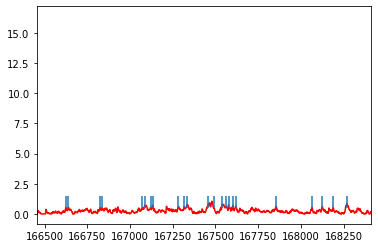

In [74]:
plt.plot(np.asarray(sess_info['pop_rate'])/100,color='r')
plt.eventplot(sess_info['id_peaks'])
plt.xlim([len(sess_info['pop_rate'])-2000,len(sess_info['pop_rate'])-40])

cluster [] is removed
(30, 30)
exclude cluster is  [] mixed clusters are  [ 4.6866856 23.        24.       ]
(29, 29)
exclude cluster is  [] mixed clusters are  [ 4.26015458 14.         15.        ]
(28, 28)
exclude cluster is  [] mixed clusters are  [ 4.1423313 23.        26.       ]
(27, 27)
exclude cluster is  [] mixed clusters are  [ 4.03463758  9.         21.        ]
(26, 26)
exclude cluster is  [] mixed clusters are  [ 3.68326878 18.         19.        ]
(25, 25)
exclude cluster is  [] mixed clusters are  [ 3.56383173 22.         23.        ]
(24, 24)
exclude cluster is  [] mixed clusters are  [ 2.92262818 22.         23.        ]
(23, 23)
exclude cluster is  [] mixed clusters are  [ 2.68891508  7.         13.        ]
(22, 22)
exclude cluster is  [] mixed clusters are  [ 2.87617048 12.         15.        ]
(21, 21)
exclude cluster is  [] mixed clusters are  [2.64513652 3.         4.        ]
(20, 20)
exclude cluster is  [] mixed clusters are  [ 2.62367111  4.         14.       

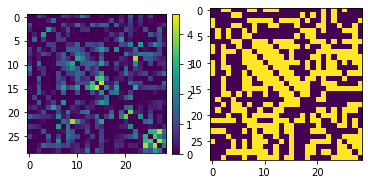

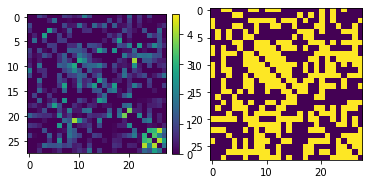

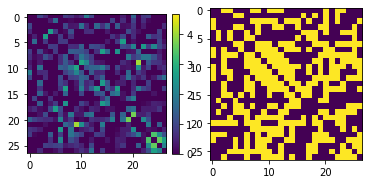

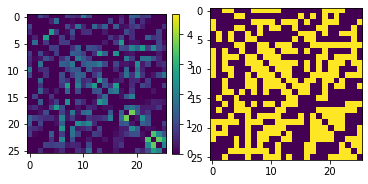

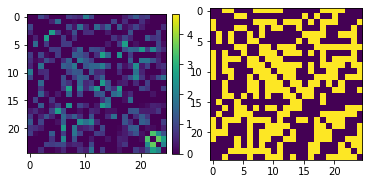

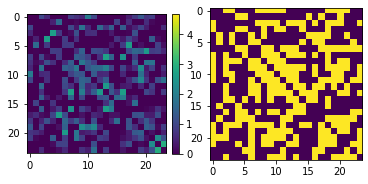

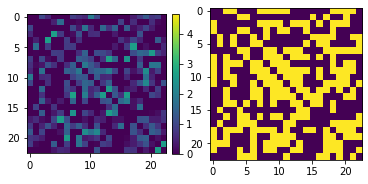

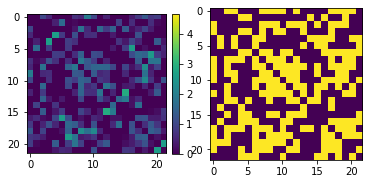

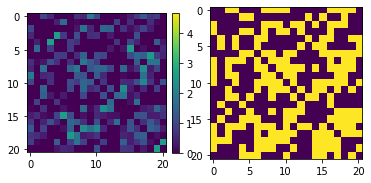

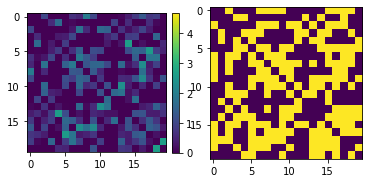

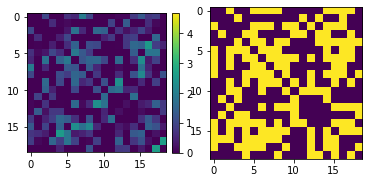

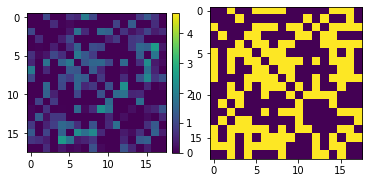

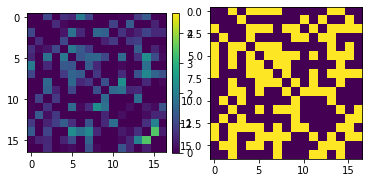

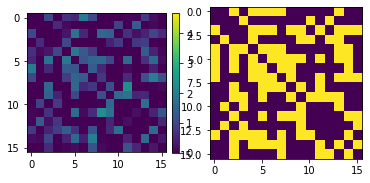

In [75]:
#poprate,id_peaks,bursts,seqs,spike_times,rasters = mot.binned_burst(dats['sp_data'],winlen,thr_burts,fs,timewins)
seqs=sess_info['seqs']# clustering will be done on all sequences (correct and failed trials). 
plot_figure=True
bursts=sess_info['bursts']
#id_peaks=sess_info['id_peaks']
#*************** compute clusters from sequences
repid,nsig,pval,bmat,zmat,corrmat = mot.allmot(seqs,nrm);
ids_clust = mot.cluster(bmat,zmat,clstr_param)
temp_info = mot.templates(bursts,seqs,nrm,ids_clust,min_ratio = min_ratio)
print('cluster', temp_info['exclude'] ,'is removed')
#temp_info_org=np.copy(temp_info['template'])
temp_info_test = copy.deepcopy(temp_info)
temp_info_new,mask = mot.merge_clusters2(temp_info,nrm,seqs,bursts,plot_figure,min_ratio=.1,z_thr=2.5)
#id_peaks=dats['sp_idpeak']
sess_info['ids_clust'] = temp_info_new['ids_clust'][0]

sess_inf_plus_mask= {'sess_info': sess_info, 'Masks': Masks}
with open(savefolder+fol+'Sesseion_info'+'_'+dataphase,'wb') as f:
    pickle.dump(sess_inf_plus_mask, f)